<a href="https://colab.research.google.com/github/ridwanyah24/My_fiinal_year_project/blob/main/track_and_count_vehicles_with_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install anvil-uplink
import anvil.server

anvil.server.connect("server_7ON3TXTN6D4MQGJ4XYHIAT6R-IK6TUWJSAPE3FOD6")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45227 sha256=69399270ec4e9a65a3a9021b6463841ada02d0315ab2dfbb0ab4c3f1acc26ca8
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [6]:
import cv2
import re
from google.colab.patches import cv2_imshow

## Download video

In [7]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

/content
--2023-08-10 18:23:35--  https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
Resolving docs.google.com (docs.google.com)... 74.125.197.138, 74.125.197.101, 74.125.197.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.197.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ps0fc7n44tdeejr9feqpt8qtql8ug01c/1691691750000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=6d235e5f-08e4-4711-ae27-106ef1934dd9 [following]
--2023-08-10 18:23:36--  https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ps0fc7n44tdeejr9feqpt8qtql8ug01c/1691691750000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=6d235e5f-08e4-4711-ae27-106ef1934dd9
Resolving doc-0s-ag-docs.googleusercontent.com (doc-0s-ag-docs.googleusercontent.com)... 74.125.1

In [8]:
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/traffic_video_2.mp4"

In [9]:
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)

## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **23.01.2023** with version **YOLOv8.0.17**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [10]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.151 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.5/107.7 GB disk)


## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

In [11]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [12]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [13]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [14]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [15]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [16]:
# settings
MODEL = "yolov8x.pt"

In [17]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:01<00:00, 76.2MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients


## Predict and annotate single frame

In [18]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]

In [21]:
# settings
LINE_START = Point(0, 800)
LINE_END = Point(2500, 800)

TARGET_VIDEO_PATH = f"/content/drive/MyDrive/Vehicle-counting-result.mp4"


0: 384x640 1 person, 5 cars, 2966.7ms
Speed: 6.7ms preprocess, 2966.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


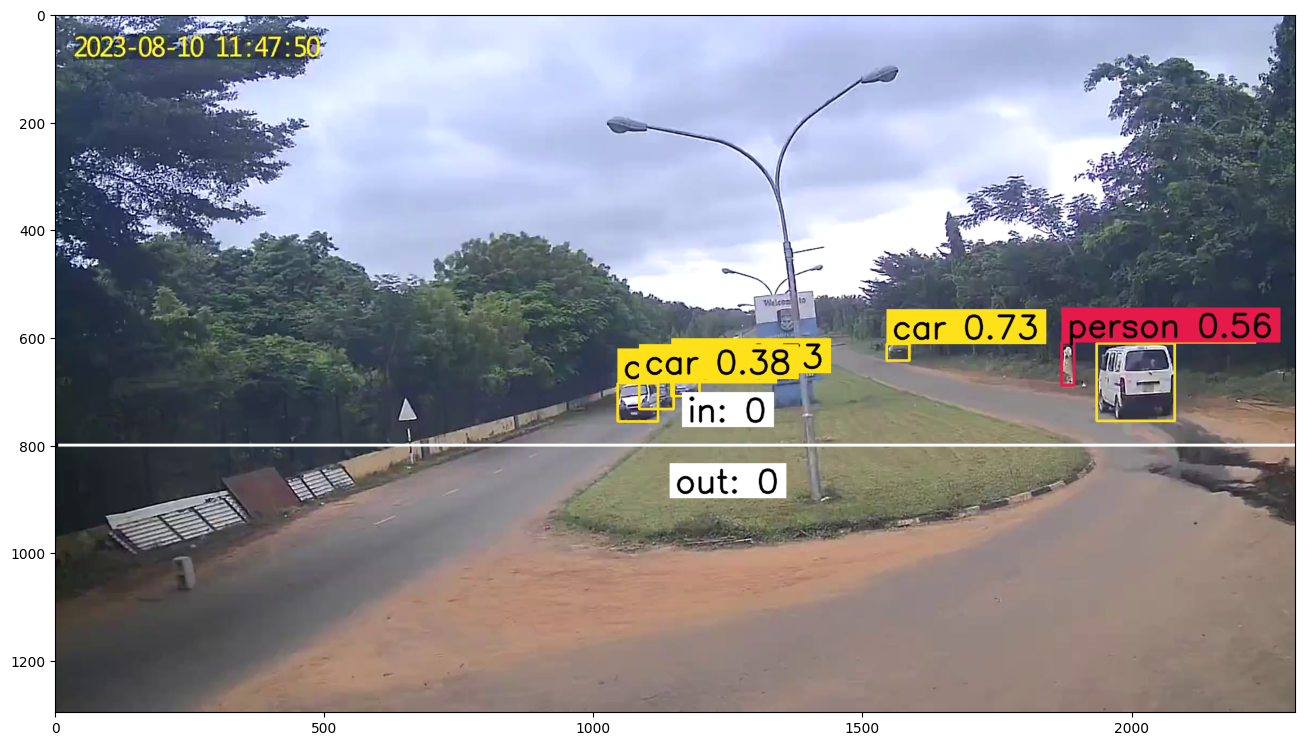

In [22]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
line_annotator.annotate(frame=frame, line_counter=line_counter)
%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Predict and annotate whole video

In [23]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
File_path = f"/content/drive/MyDrive/save_count.txt"

In [ ]:
from tqdm.notebook import tqdm
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)
# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)

#@anvil.server.callable
#def call_count():
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
  i = 0
        # loop over video frames
  for frame in tqdm(generator, total=video_info.total_frames):
      # model prediction on single frame and conversion to supervision Detections
      results = model(frame)
      detections = Detections(
          xyxy=results[0].boxes.xyxy.cpu().numpy(),
          confidence=results[0].boxes.conf.cpu().numpy(),
          class_id=results[0].boxes.cls.cpu().numpy().astype(int)
      )
      # filtering out detections with unwanted classes
      mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
      detections.filter(mask=mask, inplace=True)
      # tracking detections
      tracks = byte_tracker.update(
          output_results=detections2boxes(detections=detections),
          img_info=frame.shape,
          img_size=frame.shape
      )
      tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
      detections.tracker_id = np.array(tracker_id)
      # filtering out detections without trackers
      mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
      detections.filter(mask=mask, inplace=True)
      # format custom labels
      labels = [
          f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
          for _, confidence, class_id, tracker_id
          in detections
      ]
      # updating line counter
      line_counter.update(detections=detections)

      # annotate and display frame
      frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
      line_annotator.annotate(frame=frame, line_counter=line_counter)
      sink.write_frame(frame)
      print(line_counter.in_count + line_counter.out_count)

In [ ]:
with open(File_path, 'a') as file:
  file.write("Vehicle in count " + "= " + line_counter.in_count +'\n')
  file.write("Vehicle out count " + "= " + line_counter.out_count + '\n')
  file.write("Vehicle total count " + "= " + (line_counter.in_count + line_counter.out_count))


In [ ]:
@anvil.server.callable
def in_count():
  return line_counter.in_count

@anvil.server.callable
def out_count():
  return line_counter.out_count

@anvil.server.callable
def call():
  return out_count() + in_count()